In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings 
warnings.filterwarnings("ignore")

In [2]:
od.download("https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification")

Skipping, found downloaded files in ".\fake-news-classification" (use force=True to force download)


In [3]:
df = pd.read_csv(r"E:\Natural  Language Processing\Sentiment analysis\LSTM & RNN\fake-news-classification\WELFake_Dataset.csv")
df.shape

(72134, 4)

In [4]:
df.head()

Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA‚ÄôS ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1

In [5]:
df.drop("Unnamed: 0" , axis =1 , inplace= True)
df.head(2)

title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                NaN   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1

In [6]:
df.isna().sum()

title    558
text      39
label      0
dtype: int64

In [7]:
df.dropna(inplace=True)
print(df.isna().sum().sum())
print("the shape of the data after removing the null values : " , df.shape)

0
the shape of the data after removing the null values :  (71537, 3)


In [8]:
df.duplicated().sum()

np.int64(8416)

In [9]:
df.drop_duplicates(inplace=True)
print("the shape of the data after removing the duplicates : " , df.shape)

the shape of the data after removing the duplicates :  (63121, 3)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63121 entries, 0 to 72132
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   63121 non-null  object
 1   text    63121 non-null  object
 2   label   63121 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [11]:
X = df.drop("label" , axis =1)
y = df["label"]
print(X.shape , y.shape)

(63121, 2) (63121,)


### One Hot Representation

In [12]:
messages = X.copy()
print(messages.head(2))

                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2  UNBELIEVABLE! OBAMA‚ÄôS ATTORNEY GENERAL SAYS MO...   

                                                text  
0  No comment is expected from Barack Obama Membe...  
2   Now, most of the demonstrators gathered last ...  


In [13]:
messages

title  \
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2      UNBELIEVABLE! OBAMA‚ÄôS ATTORNEY GENERAL SAYS MO...   
3      Bobby Jindal, raised Hindu, uses story of Chri...   
4      SATAN 2: Russia unvelis an image of its terrif...   
5      About Time! Christian Group Sues Amazon and SP...   
...                                                  ...   
72127  WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...   
72129  Russians steal research on Trump in hack of U....   
72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132  Trump tussle gives unpopular Mexican leader mu...   

                                                    text  
0      No comment is expected from Barack Obama Membe...  
2       Now, most of the demonstrators gathered last ...  
3      A dozen politically active pastors came here f...  
4      The RS-28 Sarmat missile, dubbed Satan 2, will...  
5      All we can say on this one is it s about time ...  
...                                                  ...  
72127  An email released by WikiLeaks on Sunday appea...  
72129  WASHINGTON (Reuters) - Hackers believed to be ...  
72130  You know, because in fantasyland Republicans n...  
72131  Migrants Refuse To Leave Train At Refugee Camp...  
72132  MEXICO CITY (Reuters) - Donald Trump‚Äôs combati...  

[63121 rows x 2 columns]

In [14]:
messages.reset_index(inplace = True)

In [15]:
messages.head()

index                                              title  \
0      0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1      2  UNBELIEVABLE! OBAMA‚ÄôS ATTORNEY GENERAL SAYS MO...   
2      3  Bobby Jindal, raised Hindu, uses story of Chri...   
3      4  SATAN 2: Russia unvelis an image of its terrif...   
4      5  About Time! Christian Group Sues Amazon and SP...   

                                                text  
0  No comment is expected from Barack Obama Membe...  
1   Now, most of the demonstrators gathered last ...  
2  A dozen politically active pastors came here f...  
3  The RS-28 Sarmat missile, dubbed Satan 2, will...  
4  All we can say on this one is it s about time ...

In [16]:
messages.drop("index" , axis =1 , inplace=True)

In [17]:
messages["title"][0]

'LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]'

In [18]:
# Text preprocessing
lemmatizer = WordNetLemmatizer()
corpus = []

for word in range(0,len(messages)):
    review = re.sub("[^a-zA-Z]" , " " , messages["title"][word])
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords.words("english")]
    review = " ".join(review)
    corpus.append(review)

print(corpus[0])

law enforcement high alert following threat cop white blacklivesmatter fyf terrorist video


In [19]:
messages["title"][0]

'LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]'

In [20]:
# Vocabulary Size
voc_size = 5000

In [21]:
onehot_repr = [one_hot(word, voc_size) for word in corpus]
onehot_repr[0]

[2380, 2275, 2767, 1064, 3144, 1289, 1791, 2085, 4215, 4674, 1749, 3646]

In [22]:
max_length = 0
for i in onehot_repr:
    if len(i) > max_length:
        max_length = len(i)

print("the max length for corpus :" , max_length)

the max length for corpus : 47


### Embedding Representation

In [23]:
sent_length = 50
embedded_docs = pad_sequences(onehot_repr, padding="post",maxlen=sent_length)
print(embedded_docs[0])

[2380 2275 2767 1064 3144 1289 1791 2085 4215 4674 1749 3646    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [24]:
print(embedded_docs[1])

[1590 1801 1967 2635 4674 1377 2715  736 2106 3412 4375 2855 2167 3646
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Creating Model with Embedding later and LSTM

In [25]:
embedding_vector_features = 40

model = Sequential([
    Embedding(voc_size , embedding_vector_features , input_length = sent_length),
    Dropout(0.2),
    LSTM(200),
    Dropout(0.3),
    Dense(1,activation="sigmoid")
])

model.compile(loss = "binary_crossentropy" , optimizer = "adam" , metrics =["accuracy"])
model.build(input_shape=(None,sent_length))
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding (Embedding)           ‚îÇ (None, 50, 40)         ‚îÇ       200,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 50, 40)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                     ‚îÇ (None, 200)            ‚îÇ       192,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 200)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ           201 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 393,001 (1.50 MB)

 Trainable params: 393,001 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
len(embedded_docs) , y.shape

(63121, (63121,))

In [27]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [28]:
X_final.shape , y_final.shape

((63121, 50), (63121,))

In [30]:
X_train, X_valid , y_train, y_valid = train_test_split(X_final,y_final , test_size = 0.2 , shuffle=True , random_state = 0)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(50496, 50) (12625, 50) (50496,) (12625,)


In [31]:
X_test = X_train[:5000]
y_test = y_train[:5000]

X_train = X_train[5000:]
y_train = y_train[5000:]
print(X_test.shape, X_train.shape , y_train.shape, y_test.shape)

(5000, 50) (45496, 50) (45496,) (5000,)


In [32]:
early_stopping = EarlyStopping(patience=3 , restore_best_weights=True)
checkpoint = ModelCheckpoint("FakeNewsModel_LSTM.keras" , save_best_only=True)

In [33]:
history = model.fit(X_train, y_train ,validation_data = (X_valid, y_valid),epochs=50 , 
          batch_size=128 , callbacks=[early_stopping , checkpoint] )

Epoch 1/50
356/356 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 43s 110ms/step - accuracy: 0.5523 - loss: 0.6885 - val_accuracy: 0.5461 - val_loss: 0.6889
Epoch 2/50
356/356 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 110ms/step - accuracy: 0.5917 - loss: 0.6475 - val_accuracy: 0.8644 - val_loss: 0.3167
Epoch 3/50
356/356 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 110ms/step - accuracy: 0.8883 - loss: 0.2765 - val_accuracy: 0.8777 - val_loss: 0.3021
Epoch 4/50
356/356 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 109ms/step - accuracy: 0.9099 - loss: 0.2277 - val_accuracy: 0.8709 - val_loss: 0.2975
Epoch 5/50
356/356 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 110ms/step - accuracy: 0.9195 - loss: 0.2072 - val_accuracy: 0.8741 - val_loss: 0.2932
Epoch 6/50
356/356 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 113ms/step - accuracy: 0.9244 - loss: 0.1933 - val_accuracy: 

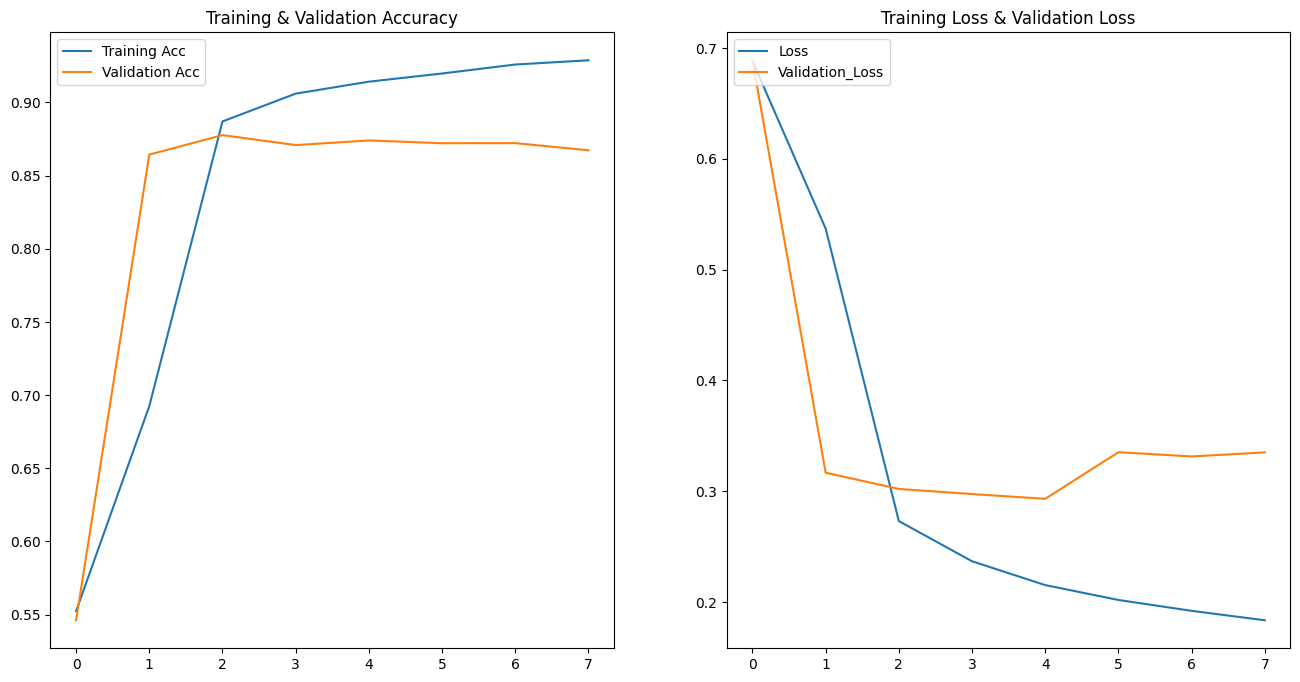

In [34]:
loss = history.history["loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs_range = range(len(accuracy))

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, accuracy, label="Training Acc")
plt.plot(epochs_range, val_accuracy, label = "Validation Acc")
plt.title("Training & Validation Accuracy")
plt.legend(loc="upper left")


plt.subplot(1,2,2)
plt.plot(epochs_range, loss , label="Loss")
plt.plot(epochs_range , val_loss , label='Validation_Loss')
plt.title("Training Loss & Validation Loss")
plt.legend(loc="upper left")

plt.show()

In [35]:
y_pred = model.predict(X_test)


157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 19ms/step


In [37]:
y_pred=np.where(y_pred > 0.6, 1,0) 

In [39]:
cm = confusion_matrix(y_pred, y_test)
cm

array([[2521,  397],
       [ 246, 1836]])

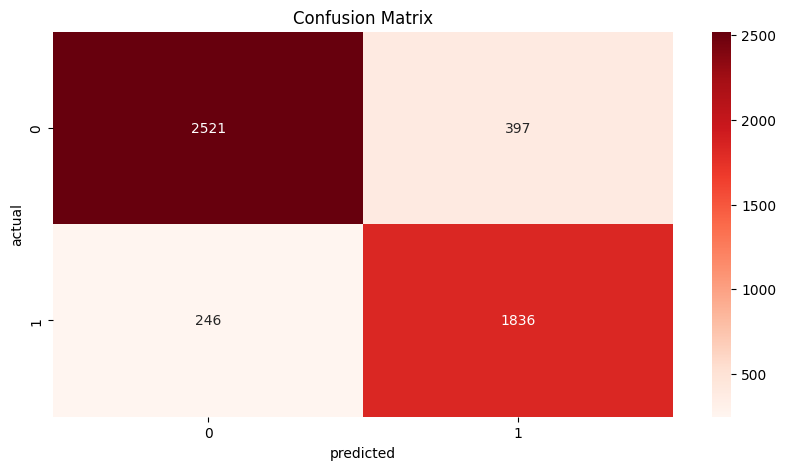

In [41]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(cm , annot= True, cmap="Reds" , fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [42]:
print("üí† Classification Report :")
print(classification_report(y_test, y_pred))

üí† Classification Report :
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      2767
           1       0.88      0.82      0.85      2233

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

